<a href="https://colab.research.google.com/github/sarashahin/Badger_AI/blob/main/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Parse the XML files to map images to their badger IDs.

In [2]:
import os
import xml.etree.ElementTree as ET
import random
from itertools import combinations
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision


# Set mixed precision policy
mixed_precision.set_global_policy('mixed_float16')



# Parse XML annotations
def parse_annotations(annotation_dir):
    annotations = {}
    for file in os.listdir(annotation_dir):
        if file.endswith('.xml'):
            tree = ET.parse(os.path.join(annotation_dir, file))
            root = tree.getroot()
            image_id = root.find('filename').text
            object_element = root.find('object')
            if object_element is not None:
                badger_id = object_element.find('name').text
                if badger_id not in annotations:
                    annotations[badger_id] = []
                annotations[badger_id].append(image_id)
            else:
                print(f"No <object> found in {file}")
    return annotations

annotations_dir = '/content/drive/MyDrive/Annotation2'
annotations = parse_annotations(annotations_dir)
print(annotations)




No <object> found in IMG_0036_frame_1200.xml
{'Badger_1_Face_Stripe': ['2 badgers feeding 2_frame_0.jpg', '2 badgers feeding 2_frame_60.jpg', '2 badgers feeding 2_frame_120.jpg', '2 badgers feeding 2_frame_180.jpg', '2 badgers feeding 2_frame_240.jpg', '2 badgers feeding 2_frame_300.jpg', '2 badgers feeding 2_frame_360.jpg', '2 badgers feeding 2_frame_420.jpg', '3 badgers feeding 5_frame_0.jpg', '3 badgers feeding 5_frame_60.jpg', '3 badgers feeding 5_frame_120.jpg', '3 badgers feeding 5_frame_180.jpg', '3 badgers feeding 5_frame_240.jpg', '3 badgers feeding 5_frame_300.jpg', '3 badgers feeding 5_frame_360.jpg', '3 badgers feeding 5_frame_420.jpg'], 'Badger_5_Fur_Grey': ['badger_mum_with_2_cubs_1_frame_1980.jpg', 'badger_mum_with_2_cubs_1_frame_1320.jpg', 'badger_mum_with_2_cubs_1_frame_2040.jpg', 'badger_mum_with_2_cubs_1_frame_2100.jpg', 'badger_mum_with_2_cubs_1_frame_2160.jpg', 'badger_mum_with_2_cubs_1_frame_2220.jpg', 'badger_mum_with_2_cubs_1_frame_2280.jpg', 'badger_mum_with_2_

Generate pairs of images based on annotations.

In [4]:
def generate_pairs(annotations):
    positive_pairs = []
    negative_pairs = []
    badger_ids = list(annotations.keys())

    for badger_id in badger_ids:
        image_list = annotations[badger_id]
        if len(image_list) > 1:
            image_combinations = combinations(image_list, 2)
            positive_pairs.extend(list(image_combinations))

    for _ in range(len(positive_pairs) // 2):  #  half of the data
        badger1, badger2 = random.sample(badger_ids, 2)
        image1 = random.choice(annotations[badger1])
        image2 = random.choice(annotations[badger2])
        negative_pairs.append((image1, image2))

    return positive_pairs[:len(positive_pairs)//2], negative_pairs

positive_pairs, negative_pairs = generate_pairs(annotations)


# pairs for verification
print("Positive pairs:", positive_pairs[:5])
print("Negative pairs:", negative_pairs[:5])

Positive pairs: [('2 badgers feeding 2_frame_0.jpg', '2 badgers feeding 2_frame_60.jpg'), ('2 badgers feeding 2_frame_0.jpg', '2 badgers feeding 2_frame_120.jpg'), ('2 badgers feeding 2_frame_0.jpg', '2 badgers feeding 2_frame_180.jpg'), ('2 badgers feeding 2_frame_0.jpg', '2 badgers feeding 2_frame_240.jpg'), ('2 badgers feeding 2_frame_0.jpg', '2 badgers feeding 2_frame_300.jpg')]
Negative pairs: [('mum_with_cub_frame_2280.jpg', 'IMG_0082_frame_180.jpg'), ('IMG_0069_frame_1320.jpg', 'dominate_female_with_cubs_frame_2100.jpg'), ('IMG_0015_frame_3120.jpg', 'IMG_0003 (2)_frame_960.jpg'), ('dominate_female_with_cubs_frame_2940.jpg', 'mum_with_cub_frame_4080.jpg'), ('mum_with_cub_frame_2820.jpg', 'IMG_0003_frame_4320.jpg')]


3. Prepare Data for Siamese Network
Load and preprocess the images.

In [5]:
# images in parallel
def load_and_preprocess_image(image_path, target_size):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image / 255.0
    return image

def process_triplet(triplet, images_dir, target_size):
    badger_path = os.path.join(images_dir, triplet[0])
    positive_path = os.path.join(images_dir, triplet[1])
    negative_path = os.path.join(images_dir, triplet[2])
    badger = load_and_preprocess_image(badger_path, target_size)
    positive = load_and_preprocess_image(positive_path, target_size)
    negative = load_and_preprocess_image(negative_path, target_size)
    return badger, positive, negative


In [6]:
def generate_triplets(positive_pairs, negative_pairs):
    triplets = []
    for pos_pair in positive_pairs:
        badger = pos_pair[0]
        positive = pos_pair[1]
        negative = random.choice(negative_pairs)[1]
        triplets.append((badger, positive, negative))
    return triplets

# Create triplets for training
images_dir = '/content/drive/MyDrive/extracted_frames'
target_size = (200, 200)

triplets = generate_triplets(positive_pairs, negative_pairs)
train_triplets, val_triplets = train_test_split(triplets, test_size=0.2, random_state=42)

In [7]:

def triplet_generator(triplets, images_dir, target_size=(200, 200)):
    def generator():
        for triplet in triplets:
            badger, positive, negative = process_triplet(triplet, images_dir, target_size)
            yield (badger, positive, negative), 1  # Include label
    return generator


# Create datasets
train_dataset = tf.data.Dataset.from_generator(
    triplet_generator(train_triplets, images_dir, target_size),
    output_signature=(
        (tf.TensorSpec(shape=(200, 200, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(200, 200, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(200, 200, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.int32))
)

val_dataset = tf.data.Dataset.from_generator(
    triplet_generator(val_triplets, images_dir, target_size),
    output_signature=(
        (tf.TensorSpec(shape=(200, 200, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(200, 200, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(200, 200, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.int32))
)




# Batch and prefetch datasets
train_dataset = train_dataset.cache().shuffle(1000).batch(8).repeat().prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache().batch(8).repeat().prefetch(tf.data.experimental.AUTOTUNE)


# steps_per_epoch
steps_per_epoch = len(train_triplets) // 8
validation_steps = len(val_triplets) // 8



Implement the Siamese network with triplet loss.

In [8]:
# Model creation and training steps as before
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def create_base_network(input_shape):
    base_cnn = ResNet50(weights="imagenet", input_shape=input_shape, include_top=False)
    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)
    embedding = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable

    return embedding

input_shape = (200, 200, 3)
embedding = create_base_network(input_shape)


In [9]:

class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, badger, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(badger - positive), -1)
        an_distance = tf.reduce_sum(tf.square(badger - negative), -1)
        return ap_distance, an_distance

badger_input = layers.Input(name="badger", shape=input_shape)
positive_input = layers.Input(name="positive", shape=input_shape)
negative_input = layers.Input(name="negative", shape=input_shape)

distances = DistanceLayer()(
    embedding(badger_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(inputs=[badger_input, positive_input, negative_input], outputs=distances)

In [10]:

class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        (badger, positive, negative), labels = data
        with tf.GradientTape() as tape:
            ap_distance, an_distance = self.siamese_network([badger, positive, negative])
            loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        (badger, positive, negative), labels = data
        ap_distance, an_distance = self.siamese_network([badger, positive, negative])
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker]

siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001))

# Train the model
history = siamese_model.fit(
    train_dataset,
    epochs=8,
    validation_data=val_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


#  manage memory
K.clear_session()

Epoch 1/8


    with tf.GradientTape() as tape:
      loss = loss_fn()
      scaled_loss = opt.get_scaled_loss(loss)
    scaled_grads = tape.gradient(scaled_loss, vars)
    grads = opt.get_unscaled_gradients(scaled_grads)
    opt.apply_gradients([(grads, var)])
For more information, see https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/LossScaleOptimizer
    with tf.GradientTape() as tape:
      loss = loss_fn()
      scaled_loss = opt.get_scaled_loss(loss)
    scaled_grads = tape.gradient(scaled_loss, vars)
    grads = opt.get_unscaled_gradients(scaled_grads)
    opt.apply_gradients([(grads, var)])
For more information, see https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/LossScaleOptimizer


2743/2743 [==============================] - 1471s 509ms/step - loss: 0.0612 - val_loss: 0.0368
Epoch 2/8
2743/2743 [==============================] - 162s 59ms/step - loss: 0.0453 - val_loss: 0.0359
Epoch 3/8
2743/2743 [==============================] - 162s 59ms/step - loss: 0.0457 - val_loss: 0.0348
Epoch 4/8
2743/2743 [==============================] - 162s 59ms/step - loss: 0.0552 - val_loss: 0.0351
Epoch 5/8
2743/2743 [==============================] - 161s 59ms/step - loss: 0.0414 - val_loss: 0.0363
Epoch 6/8
2743/2743 [==============================] - 162s 59ms/step - loss: 0.0439 - val_loss: 0.0377
Epoch 7/8
2743/2743 [==============================] - 162s 59ms/step - loss: 0.0422 - val_loss: 0.0504
Epoch 8/8
2743/2743 [==============================] - 160s 59ms/step - loss: 0.0416 - val_loss: 0.0385


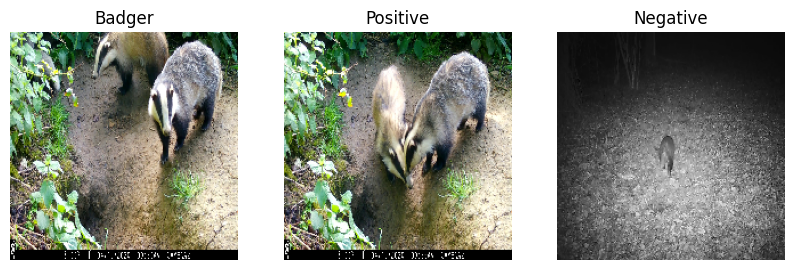

Positive similarity: 0.99982417
Negative similarity: 0.9990008


In [14]:
import tensorflow as tf
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

# visualize images
def visualize(badger, positive, negative):
    def show(ax, image):
        ax.imshow(image)
        ax.axis('off')

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    show(ax[0], badger[0])
    ax[0].set_title('Badger')
    show(ax[1], positive[0])
    ax[1].set_title('Positive')
    show(ax[2], negative[0])
    ax[2].set_title('Negative')
    plt.show()

# sample from the dataset
sample = next(iter(train_dataset))

# display the sample
(badger, positive, negative), _ = sample
visualize(badger, positive, negative)

# Compute embeddings
badger_embedding, positive_embedding, negative_embedding = (
    embedding(badger),
    embedding(positive),
    embedding(negative),
)

# Compute cosine similarity
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(badger_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(badger_embedding, negative_embedding)
print("Negative similarity:", negative_similarity.numpy())

